# Import Libraries

In [3]:
import os
import time
from threading import Thread

import numpy as np
from math import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from pltfigure import pltfigure

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

3 Physical GPUs, 3 Logical GPUs


True

In [5]:
class ThreadWithReturnValue(Thread):
    def __init__(self, group=None, target=None, name=None,
args=(), kwargs={}, Verbose=None):
        Thread.__init__(self, group, target, name, args, kwargs)
        self._return = None
    def run(self):
        if self._target is not None:
            self._return = self._target(*self._args,
                                                **self._kwargs)
    def join(self, *args):
        Thread.join(self, *args)
        return self._return

# Functions

In [6]:
#This is parameter space
# m*x''+c*x'+mx = 0
# => x'' + 2jwx' +w^2 x =0 , j = c/(2wm) , w = sqrt(k/m)
w = np.linspace(0.01, 1, 10)
z = np.linspace(0.01, 0.99, 10)
x0 = np.linspace(0, 1, 10)
v0 = np.linspace(0, 1, 10)

t = np.linspace(0.1, 100, 1000)


inputData = np.array(np.meshgrid(w,z,x0,v0)).T.reshape(-1, 4)

# OUR DIFFERENTIAL EQ.

In [7]:
def finalsolution(W,Z,X0,V0,T):
    # final sol is x = e^(-zwt) (x0cos(wnt)+ ((v0+z*wn*x0)/wn)*sin(wnt)) wn = w sqrt(1-z**2)
    WN = W * np.sqrt(1-Z**2)
    try:
        res = np.exp(-Z*W*T) * (X0*np.cos(WN*T) + ((V0 + Z *WN *X0)/WN)*np.sin(WN *T))
    except RuntimeWarning as e:
        print(WN)
    finally:
        return res 

x = list()

for case in inputData:
    x.append(finalsolution(case[0],case[1],case[2],case[3],t))
x = np.array(x)


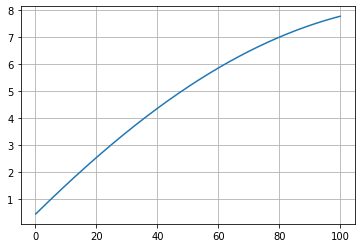

In [8]:
plt.plot(t,x[1402,:])
plt.grid()

In [7]:
zeroline = np.zeros((np.shape(x)[0],len(t)))
print(np.shape(x),np.shape(zeroline))
#pltfigure(zeroline,x,t,"Dataset","Zeroline",'dataset2.gif')

(10000, 1000) (10000, 1000)


In [8]:
def scale(ar, ar_scaled_min, ar_scaled_max):
    ar_min = np.amin(ar)
    ar_max = np.amax(ar)
    ar_scaled = ((ar - ar_min) / (ar_max - ar_min)) * (ar_scaled_max - ar_scaled_min) + ar_scaled_min
    return ar_min, ar_max, ar_scaled

# Split Data

In [9]:
randomChoise = np.random.choice(range(inputData.shape[0]), size=(round(0.75*len(inputData)),), replace=False)
train_ind = [i for i in range(0,x.shape[0]) if i not in randomChoise]
test_ind = [i for i in range(0,x.shape[0]) if i in randomChoise]

randomChoise2 = np.random.choice(range(len(test_ind)), size=(round((9.97/10)*len(test_ind)),), replace=False)

valid_ind = [test_ind[i] for i in range(0,len(test_ind)) if i not in randomChoise2]
test_ind = [test_ind[i] for i in range(0,len(test_ind)) if i in randomChoise2]

In [10]:
textfile = open("dataIndexes.dat","w")
for element in train_ind:
    textfile.write(str(element) + " ")
textfile.write('\n')
for element in valid_ind:
    textfile.write(str(element) + " ")
textfile.write('\n')
for element in test_ind:
    textfile.write(str(element) + " ")
textfile.close()

In [11]:
split = 250
xTrain_ind = np.array_split(train_ind,split,axis=0)
xTest_ind = np.array_split(test_ind,split,axis=0)

In [12]:
np.shape(valid_ind),np.shape(train_ind) , np.shape(test_ind)

((22,), (2500,), (7478,))

# Concatenate Dataset for Input

In [13]:
n_steps = 30
tNodes = len(t)

In [14]:
def makeFasterInputData(ind):
    #allocate whole array
    X = np.empty(((tNodes-n_steps)* len(ind) ,n_steps,1))
    Y = np.empty(((tNodes-n_steps)* len(ind)))
    for j in range(len(ind)): 
        for k in range(tNodes-n_steps):
            X[(tNodes-n_steps)*j+k,:,0] = x[ind[j],k:k+n_steps]
            Y[(tNodes-n_steps)*j+k] = x[ind[j],k+n_steps]
    return X , Y

In [15]:
a ,b = makeFasterInputData(xTrain_ind[2])
np.shape(a) , np.shape(b)

((9700, 30, 1), (9700,))

# Create Model Name

In [ ]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y-%H:%M")

model_name = 'lstm'+dt_string+'.h5'
model_name = os.path.join("Models", model_name)

# Create Model

In [ ]:
def LSTM_DNN(name_model):
    inp = Input(shape=(n_steps, 1))
    x1 = LSTM(101, activation='tanh', return_sequences=True, use_bias=True)(inp)
    x2 = LeakyReLU(alpha=0.4)(x1)
    x3 = LSTM(101, activation='tanh', use_bias=True)(x2)
    x4 = LeakyReLU(alpha=0.4)(x3)
    flat = Flatten()(x4)
    x5 = Dense(101, activation=None, use_bias=True)(flat)
    x6 = LeakyReLU(alpha=0.4)(x5)
    x7 = Dense(1, activation='linear', use_bias=True)(x6)
    model = Model(inputs=[inp], outputs=x7)

    model.summary()
    #model.save(name_model)
    return model

In [ ]:
lstm_model = LSTM_DNN(model_name)
print(lstm_model)

# Train Model With Callbacks to File

In [ ]:
optimizer = keras.optimizers.Adam()

loss_fn = keras.losses.Huber(name='huber_loss')
train_acc_metric = keras.metrics.MeanAbsoluteError(name='mean_absolute_error', dtype=None)
val_acc_metric = keras.metrics.MeanAbsoluteError(name='mean_absolute_error', dtype=None)

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = lstm_model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, lstm_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, lstm_model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = lstm_model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

In [ ]:
# Training Parallel Loop
num_epochs = 250

start_time = time.time()
for epoch in range(num_epochs):
    print("\n#########\nStart of epoch %d \n#########" % (epoch,))
    epoch_time = time.time()
    
    x_batch ,y_batch= makeFasterInputData(xTrain_ind[0])
    for i in range(1,split-1):
        batch_start_time = time.time()
        threadBatch = ThreadWithReturnValue(target=makeFasterInputData, args=(xTrain_ind[i],))
        threadFit = ThreadWithReturnValue(target=train_step, args=(x_batch, y_batch,))
        
        threadBatch.start()
        threadFit.start()

        x_batch , y_batch= threadBatch.join()
        loss_value = threadFit.join()
        print(f"Epoch: {epoch} Batch: {i} Loss: {loss_value}, Time: {round((time.time() - batch_start_time),3)}")

    loss_value = train_step(x_batch, y_batch)
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training MAE over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    x_batch_val ,y_batch_val = makeFasterInputData(valid_ind)
    test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % round((time.time() - epoch_time),3))

print(f"Total Time taken for {num_epochs} epochs: %.2fs" % round((time.time() - start_time),3))

In [ ]:
lstm_model.save(model_name)

In [ ]:
# Test Loop
x_batch ,y_batch= makeFasterInputData(xTest_ind[0])
totalTrain_acc = 0
for i in range(split-1):
    x_batch ,y_batch= makeFasterInputData(xTest_ind[i])
    y_pred = lstm_model(x_batch, training=False)
    train_acc_metric.update_state(y_batch, y_pred)

    train_acc = train_acc_metric.result()
    totalTrain_acc = totalTrain_acc + train_acc
    print(f"Accuracy over batch: {train_acc}")
    train_acc_metric.reset_states()
print(f"Accuracy over the Whole Test Set: {totalTrain_acc}")


# Further Training WIth Its Predictions

In [ ]:
# def func(index,x_ind):

#     xModelRT = x[index,:n_steps,:]
#     xModel = x[index,:n_steps,:]
#     yModelPred = x[index,:n_steps,:]
#     yModelPredRT = x[index,:n_steps,:]

#     for j in range(t.shape[0] - n_steps):
#         if j%390 == 0:
#             print(f"index: {index}: {j/(t.shape[0] - n_steps)*100}")

#         predRT = lstm_model.predict(np.expand_dims(xModelRT, axis=0))
#         predRT = np.squeeze(predRT)
#         yModelPredRT = np.vstack([yModelPredRT,predRT])
#         xModelRT = yModelPredRT[-n_steps:,:]

#         pred = lstm_model.predict(np.expand_dims(xModel, axis=0))
#         pred = np.squeeze(pred)
#         yModelPred = np.vstack([yModelPred,pred])
#         xModel = u[i,j:n_steps+j,:]

In [ ]:
# start_super_calcs= time.time()
# x_index = 40
# if __name__ == "__main__":
  
#     # print ID of current process
#     print("ID of process running main program: {}".format(os.getpid()))
  
#     # print name of main thread
#     print("Main thread name: {}".format(threading.current_thread().name))
#     threads = []
#     for i in something:
#         thread = threading.Thread(target=func, args=(i,x_index,))
#         threads.append(thread)
        
#     for i in range(len(something)):
#         threads[i].start()
    
#     for i in range(len(something)):
#         threads[i].join()

# print(f"it took {(time.time() - start_super_calcs)}")